## Project 2: Exploring the Uganda's milk imports and exports
A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the Uganda's imports and exports of milk in 2015:

* How much does the Uganda export and import and is the balance positive (more exports than imports)?
* Which are the main trading partners, i.e. from/to which countries does the Uganda import/export the most?
* Which are the regular customers, i.e. which countries buy milk from the Uganda every month?
* Which countries does the Uganda both import from and export to?

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and preparing the data

The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly 
- Periods: Jan - May 2018
- Reporter: Uganda
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 401 (Milk and cream, neither concentrated nor sweetened) and 402 (Milk and cream, concentrated or sweetened)

In [2]:
LOCATION = 'comrade_milk_ug_jan_dec_2015.csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero.

In [3]:
import pandas as pd
milk = pd.read_csv(LOCATION, dtype={'Commodity Code':str})
milk.tail(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
289,HS,2015,201512,Dec-15,4,0,2,Exports,800,Uganda,...,NaN,NaN,NaN,NaN,3000.0,NaN,991,NaN,NaN,0
290,HS,2015,201512,Dec-15,4,0,2,Exports,800,Uganda,...,NaN,NaN,NaN,NaN,18930.0,NaN,56999,NaN,NaN,0


The data only covers the first five months of 2015. Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [4]:
def milkType(code):
    if code == '401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '402': # concentrated or sweetened
        return 'processed' 
    return 'unknown'

COMMODITY = 'Milk and cream'
milk[COMMODITY] = milk['Commodity Code'].apply(milkType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
milk = milk[headings]
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,201501,World,Imports,unprocessed,3671
1,201501,World,Exports,unprocessed,473724
2,201501,Burundi,Exports,unprocessed,19996
3,201501,Denmark,Imports,unprocessed,1234
4,201501,France,Imports,unprocessed,715


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [5]:
milk = milk[milk[PARTNER] != 'World']
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
2,201501,Burundi,Exports,unprocessed,19996
3,201501,Denmark,Imports,unprocessed,1234
4,201501,France,Imports,unprocessed,715
5,201501,Rwanda,Exports,unprocessed,89479
6,201501,South Africa,Imports,unprocessed,242


In [6]:
milk.tail()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
285,201512,United Rep. of Tanzania,Exports,processed,24300
286,201512,South Sudan,Exports,processed,8064
287,201512,Rwanda,Exports,processed,64025
289,201512,Burundi,Exports,processed,991
290,201512,Dem.Rep. of the Congo,Exports,processed,56999


## Total trade flow
To answer the first question, 'how much does the Uganda export and import and is the balance positive (more exports than imports)?', the dataframe is split into two groups: exports from the Uganda and imports into the Uganda. The trade values within each group are summed up to get the total trading.

In [7]:
grouped = milk.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    35275160
Imports     2259310
Name: Trade Value (US$), dtype: int64

This shows a trade surplus of over 30 million dollars.

## Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the Uganda import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [8]:
imports = milk[milk[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('The Uganda imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the Uganda are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

The Uganda imports from 24 countries.
The 5 biggest exporters to the Uganda are:


Partner
Kenya                   1020463
Netherlands              411429
United Arab Emirates     243939
Oman                     199876
South Africa             126118
Name: Trade Value (US$), dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

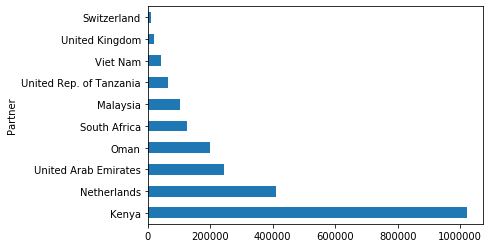

In [9]:
totalImports.head(10).plot(kind='barh')

We can deduce that Switzerland is the lowest partnering company of milk to Uganda for imports.

In [10]:
exports = milk[milk[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('The Uganda exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the Uganda are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()

The Uganda exports to 10 countries.
The 5 biggest importers from the Uganda are:


Partner
Kenya                      30237033
South Sudan                 2533575
Rwanda                       869466
United Rep. of Tanzania      533366
Japan                        446596
Name: Trade Value (US$), dtype: int64

## Regular importers

Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy milk from the Uganda every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [11]:
def buysEveryMonth(group):
    reply = len(group) == 20
    return reply

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
print(regular)
regular[(regular[MONTH] == 201501) & (regular[COMMODITY] == 'processed')]



     Period Partner Trade Flow Milk and cream  Trade Value (US$)
5    201501  Rwanda    Exports    unprocessed              89479
15   201502  Rwanda    Exports    unprocessed              40316
28   201501  Rwanda    Exports      processed              28170
30   201501   Kenya    Exports      processed             164116
46   201502  Rwanda    Exports      processed               9870
53   201503   Kenya    Exports    unprocessed             427005
54   201503  Rwanda    Exports    unprocessed              60944
62   201504   Kenya    Exports    unprocessed             164518
65   201504  Rwanda    Exports    unprocessed              55548
81   201503   Kenya    Exports      processed            2889812
93   201504  Rwanda    Exports      processed               8794
96   201504   Kenya    Exports      processed             491255
102  201505   Kenya    Exports    unprocessed             823719
104  201505  Rwanda    Exports    unprocessed              51333
115  201506   Kenya    Ex

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
28,201501,Rwanda,Exports,processed,28170
30,201501,Kenya,Exports,processed,164116


Just over 5% of the total Uganda exports are due to these regular customers.

In [12]:
regular[VALUE].sum() / exports[VALUE].sum()

0.8818244623128569

## Bi-directional trade

To address the fourth question, 
'Which countries does the Uganda both import from and export to?', a pivot table is used to list the total export and import value for each country. 

In [13]:
countries = pivot_table(milk, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Australia,NaN,17.0
Burundi,262905.0,NaN
China,NaN,5179.0
Dem.Rep. of the Congo,188248.0,48.0
Denmark,NaN,3780.0


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the Uganda.

In [14]:
countries.dropna()

Trade Flow,Exports,Imports
Partner,,
Dem.Rep. of the Congo,188248.0,48.0
Kenya,30237033.0,1020463.0
Rwanda,869466.0,3096.0
United Arab Emirates,90939.0,243939.0
United Rep. of Tanzania,533366.0,65472.0


## Conclusions

The milk and cream trade of the Uganda from January to December 2015 was analysed in terms of which countries the Uganda mostly depends on for income (exports) and goods (imports). Over the period, the Uganda had a trade surplus of over 1 million US dollars.

Kenya is the main partner, but it exported from the Uganda almost the triple in value than it imported to the Uganda. 

The Uganda exported to over 100 countries during the period, but only imported from 24 countries, the main ones (top five by trade value) being not so geographically close (Kenya, Netherlands, United Arab Emirates, Oman, and South Africa). Kenya and Netherlands are the main importers that are not also main exporters except Kenya. 

The Uganda is heavily dependent on its regular customers, the 10 countries that buy all types of milk and cream every month. They contribute three quarters of the total export value.

Although for some, the trade value (in US dollars) is suspiciously low, which raises questions about the data's accuracy.
